In [9]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts as ef


In [40]:
# INPUT CELL

summary = 'Perform fit on canon_g1 pseudodata with GP -> Blg + NFW + Iso'
gpu_id = '0'

mod_id = 0
svi_id = 0
sim_seed = 0 ; str_sim_seed = str(sim_seed)

# Important Fit Settings 
rig_temp_list = ['psc', 'bub'] # 'iso', 'psc', 'bub'
hyb_temp_list = ['pib', 'ics'] # pib, ics, blg
var_temp_list = [] # nfw, dsk

is_gp = True
gp_deriv = False

data_file = 'canon_g1'
rig_temp_sim = ['iso', 'psc', 'bub']
hyb_temp_sim = ['pib', 'ics', 'blg']
var_temp_sim = ['nfw']
is_custom_blg = False
custom_blg_id = 0

Nu = 300
u_option = 'fixed' # 'float' or 'fixed'
u_grid_type = 'sunflower'
u_weights = 'data'

Np = 50
p_option = 'match_u' # 'float' or 'fixed'
Nsub = 500

# Rest of parameters set to default values
ebin = 10
is_float64 = False
debug_nans = False
no_ps_mask = False
p_grid_type = 'healpix_bins'
p_weights = None
gp_kernel = 'Matern32'
gp_params = ['float', 'float']
gp_scale_option = 'Linear' # 'Linear' or 'Cholesky'
monotonicity_hyperparameter = 0.01
nfw_gamma = 1.
blg_names = ['mcdermott2022']

# fit specs, strings loaded for file saving

ebin = 10
str_ebin = str(ebin)

guide = 'mvn'
str_guide = guide

n_steps = 15000
str_n_steps = str(n_steps)

lr = 0.1
str_lr = str(lr)   # BE SURE TO CHANGE THIS

num_particles = 16
str_num_particles = str(num_particles)

svi_seed = 0
str_svi_seed = str(svi_seed)

In [42]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# directory where the data stored
data_dir = ef.load_data_dir(data_file)

# directory where fits stored
fit_filename, module_name = ef.generate_fit_filename(rig_temp_list, hyb_temp_list, var_temp_list, rig_temp_sim, hyb_temp_sim, var_temp_sim, is_gp, gp_deriv, is_custom_blg, custom_blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
os.system("mkdir -p "+fit_dir)

# command that converts numbers/strings to text strings
txt = lambda x: ('\'' + str(x) + '\'')

# save settings to module

with open(fit_dir + '__init__' +  '.py', 'w') as i:
    i.write('')

with open(fit_dir + module_name + '.py', 'w') as f:
    f.write('# Important Model Settings\n')
    f.write('rig_temp_list = ' + str(rig_temp_list) + '\n')
    f.write('hyb_temp_list = ' + str(hyb_temp_list) + '\n')
    f.write('var_temp_list = ' + str(var_temp_list) + '\n')
    f.write('is_gp = ' + str(is_gp) + '\n')
    f.write('gp_deriv = ' + str(gp_deriv) + '\n')
    f.write('data_file = ' + txt(data_file) + '\n')
    f.write('rig_temp_sim = ' + str(rig_temp_sim) + '\n')
    f.write('hyb_temp_sim = ' + str(hyb_temp_sim) + '\n')
    f.write('var_temp_sim = ' + str(var_temp_sim) + '\n')
    f.write('is_custom_blg = ' + str(is_custom_blg) + '\n')
    f.write('custom_blg_id = ' + str(custom_blg_id) + '\n')
    f.write('sim_seed = ' + str(sim_seed) + '; str_sim_seed = ' + txt(sim_seed) + '\n')
    f.write('Nu = ' + str(Nu) + '\n')
    f.write('u_option = ' + txt(u_option) + '\n')
    f.write('u_grid_type = ' + txt(u_grid_type) + '\n')
    f.write('u_weights = ' + txt(u_weights) + '\n')
    f.write('Np = ' + str(Np) + '\n')
    f.write('p_option = ' + txt(p_option) + '\n')
    f.write('Nsub = ' + str(Nsub) + '\n')
    f.write('\n')
    f.write('# Rest of model parameters set to default values\n')
    f.write('ebin = ' + str(ebin) + '\n')
    f.write('is_float64 = ' + str(is_float64) + '\n')
    f.write('debug_nans = ' + str(debug_nans) + '\n')
    f.write('no_ps_mask = ' + str(no_ps_mask) + '\n')
    f.write('p_grid_type = ' + txt(p_grid_type) + '\n')
    f.write('p_weights = ' + str(p_weights) + '\n')
    f.write('gp_kernel = ' + txt(gp_kernel) + '\n')
    f.write('gp_params = ' + str(gp_params) + '\n')
    f.write('gp_scale_option = ' + txt(gp_scale_option) + '\n')
    f.write('monotonicity_hyperparameter = ' + str(monotonicity_hyperparameter) + '\n')
    if nfw_gamma == 'vary':
        f.write('nfw_gamma = ' + txt(nfw_gamma) + '\n')
    else:
        f.write('nfw_gamma = ' + str(nfw_gamma) + '\n')
    f.write('blg_names = ' + str(blg_names) + '\n\n')

# add these additional parameters and the str_ versions to text file
with open(fit_dir + module_name + '.py', 'a') as f:
    f.write('\n')
    f.write('# SVI Parameters \n')
    f.write('ebin = ' + str(ebin) + '\n')
    f.write('str_ebin = str(ebin)' + '\n')
    f.write('guide = ' + txt(guide) + '\n')
    f.write('str_guide = guide' + '\n')
    f.write('n_steps = ' + str(n_steps) + '\n')
    f.write('str_n_steps = str(n_steps)' + '\n')
    f.write('lr = ' + str(lr) + '\n')
    f.write('str_lr = ' + txt(lr) + '\n')
    f.write('num_particles = ' + str(num_particles) + '\n')
    f.write('str_num_particles = str(num_particles)' + '\n')
    f.write('svi_seed = ' + str_svi_seed + '\n')
    f.write('str_svi_seed = ' + txt(str_svi_seed))

# add summary to its own text file
with open(fit_dir + 'summary' + '.txt', 'w') as f:
    f.write(summary)

In [39]:
print(fit_dir)

/data/edr76/gce-prob-prog-gp/data/synthetic_data/canon_g1/fits/fit_7p1234567_4p3457_1p126_-1_0_0/seed_0_193/


In [12]:
from models.poissonian_ed import EbinPoissonModel

ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        )

In [13]:
# define custom optimizer (can be None if want to use default)
import optax
import numpyro
from numpyro import optim

schedule = optax.warmup_exponential_decay_schedule(
    init_value=0.005,
    peak_value=0.05,
    warmup_steps=1000,
    transition_steps=1000,
    decay_rate=1./jnp.exp(1.),
    transition_begin=5000,
)
optimizer = optim.optax_to_numpyro(
    optax.chain(
        optax.clip(1.),
        optax.adam(learning_rate=schedule), 
    )
)

In [14]:
# configure model, run SVI, and generate samp 
rng_key = jax.random.PRNGKey(svi_seed)
rng_key, key = jax.random.split(rng_key)
ebinmodel.config_model(ebin=ebin)
svi_results = ebinmodel.cfit_SVI(
    rng_key=key,
    guide=guide, 
    n_steps=n_steps, 
    lr=lr, 
    num_particles=num_particles,
    ebin=ebin, optimizer = optimizer
)
rng_key, key = jax.random.split(rng_key) 
samples = ebinmodel.cget_svi_samples(rng_key = key, num_samples=50000)

100%|██████████| 15000/15000 [05:31<00:00, 45.27it/s, init loss: 269049.6562, min loss 9648.6670, avg loss [14926-15000]: 9775.1182]


(9400.0, 10000.0)

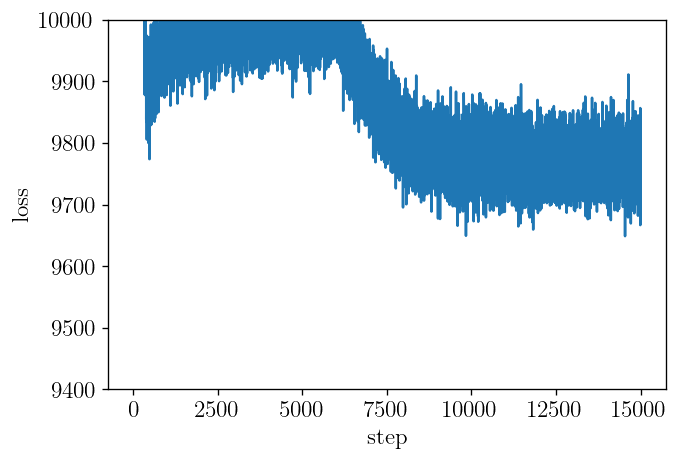

In [15]:
# loss vs step plot

plt.plot(svi_results.losses)
plt.xlabel('step')
plt.ylabel('loss')  
plt.ylim(9400,10000)

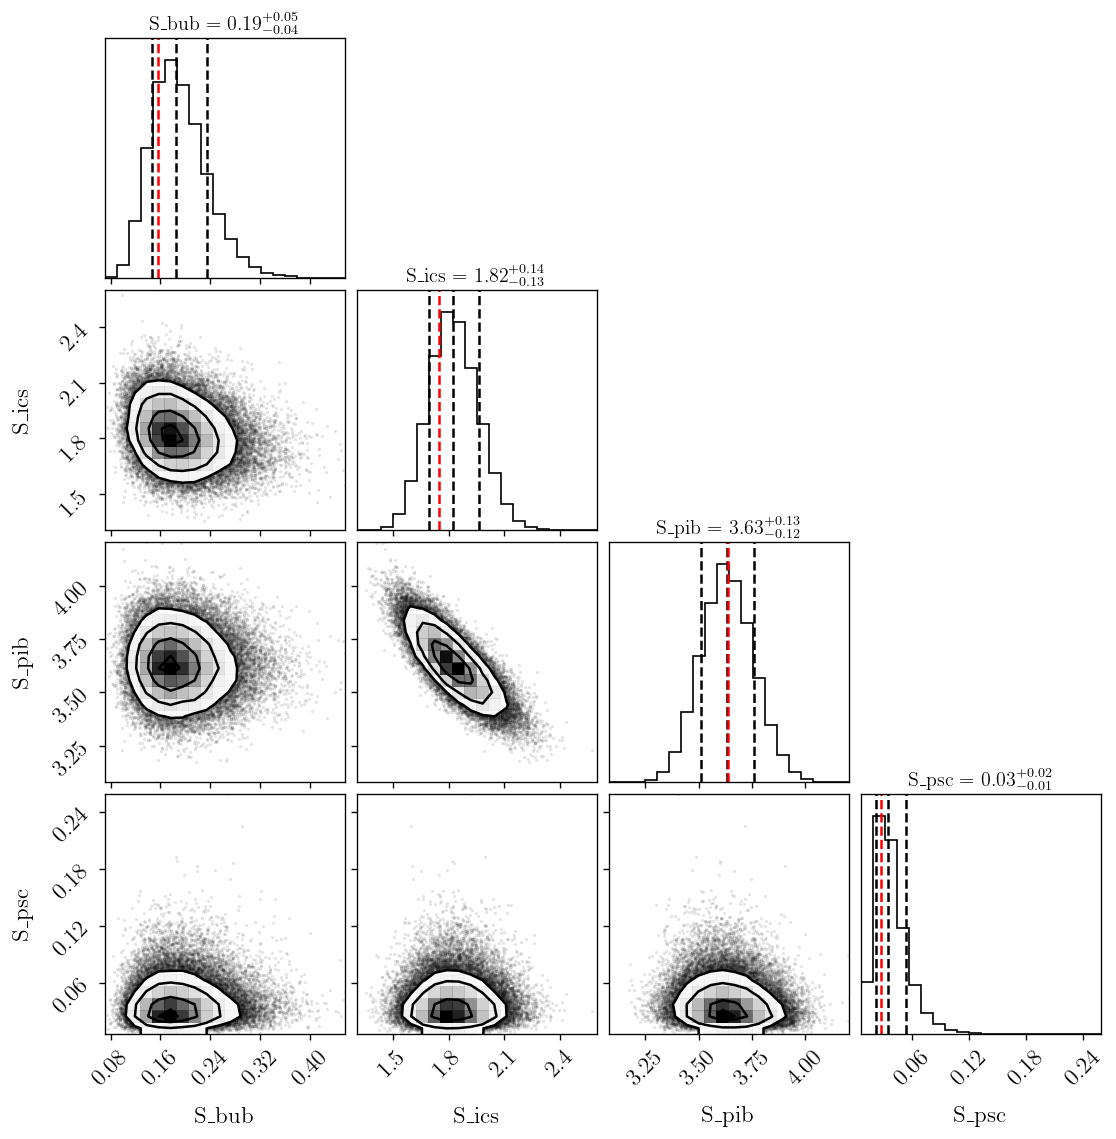

In [16]:
# summary plots of fit results
ebin = 10

temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()
fig = ef.make_corner_plots(samples, with_mean_vlines = False, sim_vlines = True, temp_dict = temp_dict)

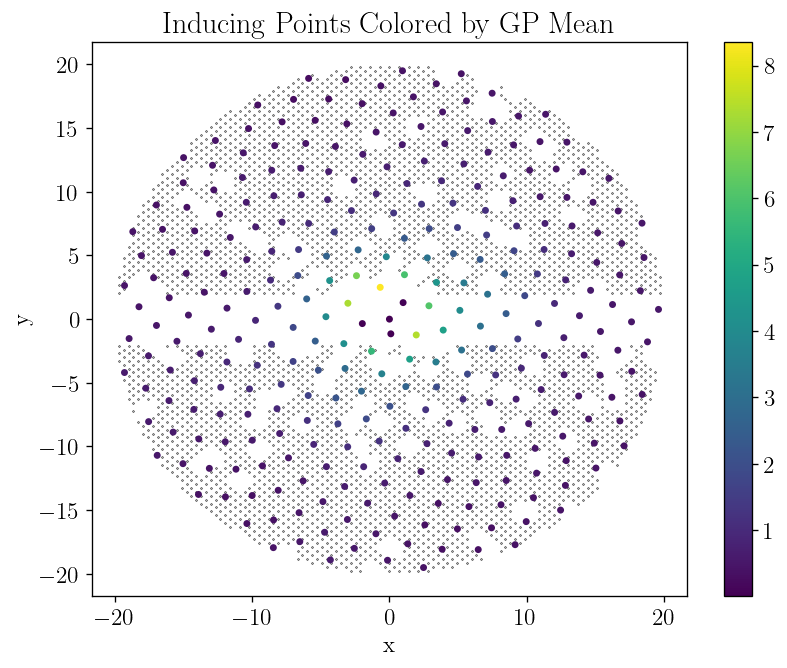

In [17]:
# plot inducing points
if is_gp:
    if u_option == 'None':
        pass
    else:

        mask = ebinmodel.mask_roi_arr[10]
        x_p = ef.get_x_from_mask(mask)
        xu_f = ef.load_inducing_points(ebinmodel, svi_results)
        mu = svi_results.params["auto_loc"]

        ef.plot_inducing_points(xu_f, x_p, mu)
else:
    print('No GP Model, No Inducing Points to Plot')

In [18]:
if is_gp:
    if u_option == 'None':
        gp_samples = samples['log_rate']
    else:
        # gp_samples = ebinmodel.get_gp_samples(num_samples=1000) # v1 (sequential)
        # gp_samples = ebinmodel.cget_gp_samples(svi_results, samples, num_samples=1000, min_loss = False) #v2 (sequential)
        ebinmodel.predictive(ebinmodel.guide, num_samples = 1, params = svi_results.params)
        rng_key, key = jax.random.split(rng_key)
        gp_samples = ebinmodel.cget_gp_samples_vec(key, 1000, svi_results) #v3 (vectorized)
else:
    print('No GP Model, No GP Samples')

/data/edr76/gce-prob-prog-gp/notebooks_v4/../utils/ed_fcts.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/data/edr76/gce-prob-prog-gp/notebooks_v4/../utils/ed_fcts.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/data/edr76/gce-prob-prog-gp/notebooks_v4/../utils/ed_fcts.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))


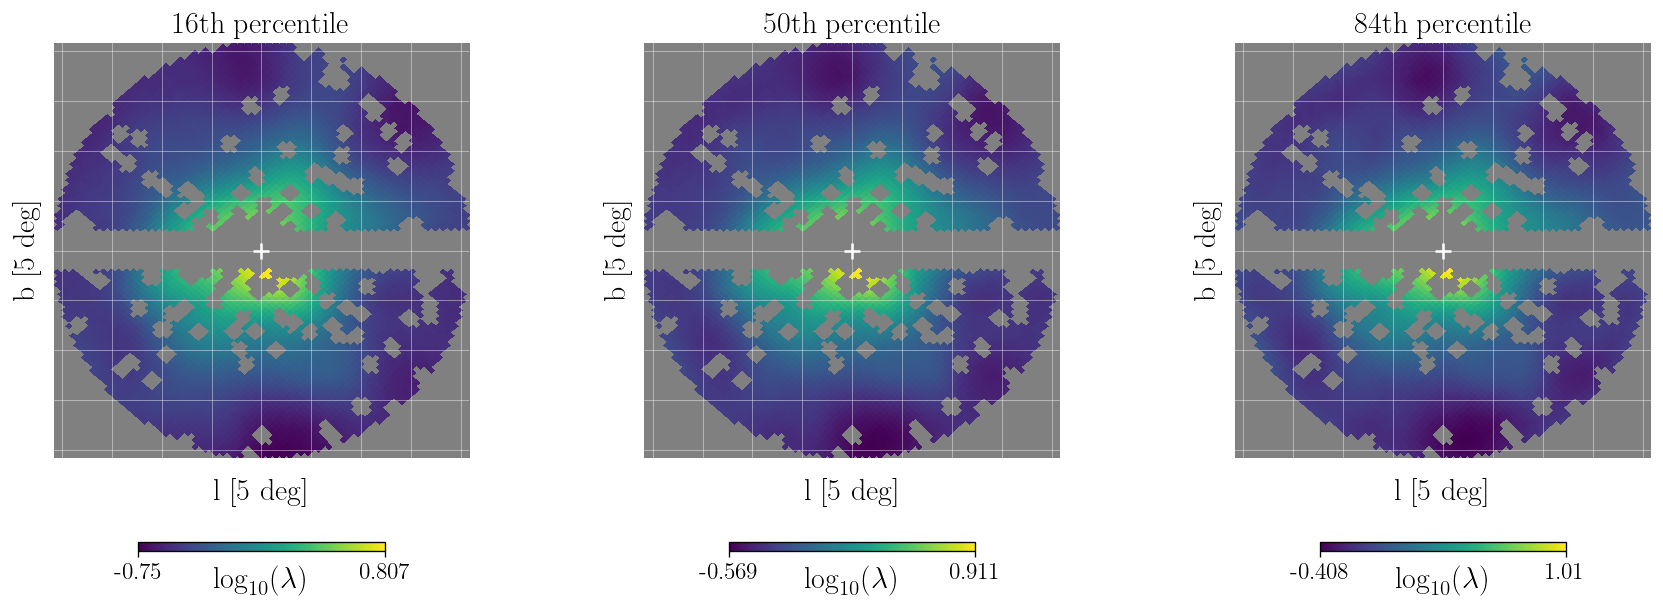

In [19]:
if is_gp:
    nside = ebinmodel.nside

    q = np.percentile(gp_samples, [16,50,84], axis = 0)

    titles = ['16th percentile', '50th percentile', '84th percentile']

    fig = plt.figure(figsize=(18, 6), dpi= 120)
    for i in range(3):
        map_p = ef.convert_masked_array_to_hp_array(np.exp(q[i]), mask, log_option = True, nside = 128)

        ax = fig.add_subplot(1,3,i+1)
        plt.axes(ax)
        title = titles[i]
        ef.gnomview_plot(map_p,title)
else:
    print('No GP Model, No GP Samples')

100%|██████████| 405/405 [00:15<00:00, 25.83it/s]


Text(0.5, 0, 'step')

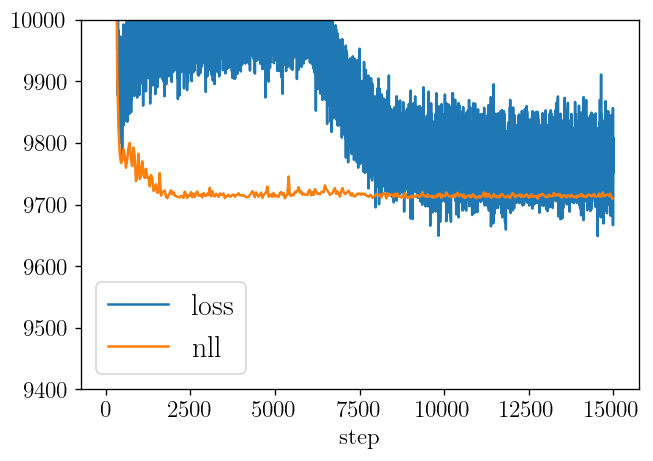

In [20]:
# note requires predictive distribution, which was loaded two cells up
ll_list = ebinmodel.recorded_log_likelihoods_1(num_samples = 16)
ll_list = jnp.array(ll_list)
losses = jnp.array(svi_results.losses)
plt.plot(losses, label = 'loss')
plt.plot(svi_results.recorded_steps, -ll_list, label = 'nll')
plt.ylim(9400,10000)
plt.legend()
plt.xlabel('step')

In [21]:
true_params = {}
true_params['S_nfw'] = temp_dict['S_nfw']
true_params['S_iso'] = temp_dict['S_iso']
true_params['S_blg'] = temp_dict['S_blg']
true_params['S_psc'] = temp_dict['S_psc']
true_params['S_bub'] = temp_dict['S_bub']
true_params['S_pib'] = temp_dict['S_pib']
true_params['S_ics'] = temp_dict['S_ics']
true_params['gamma'] = 1.
temp_q_list_norm = ebinmodel.recorded_quants(num_samples = 1000, normalized = True, true_temp_params=true_params, svi_results = svi_results)

100%|██████████| 405/405 [00:19<00:00, 20.89it/s]


(-2.0, 2.0)

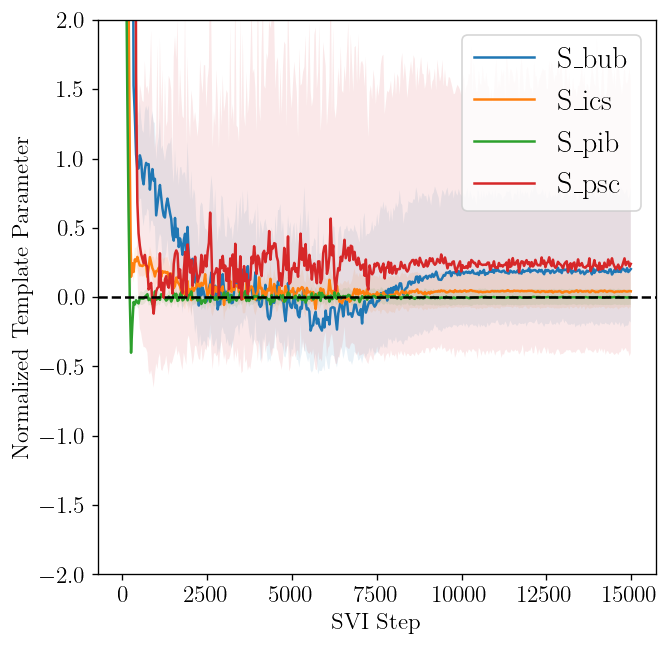

In [22]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
for k in list(temp_q_list_norm[0].keys()):
    ax.plot(svi_results.recorded_steps, [temp_q_list_norm[j][k][1] for j in range(len(temp_q_list_norm))], label = k)
    ax.fill_between(svi_results.recorded_steps, [temp_q_list_norm[j][k][0] for j in range(len(temp_q_list_norm))], [temp_q_list_norm[j][k][2] for j in range(len(temp_q_list_norm))], alpha = 0.1)
ax.legend()
ax.set_xlabel('SVI Step')
ax.set_ylabel('Normalized Template Parameter')
ax.axhline(0, color = 'k', ls = '--', alpha = 1.)
ax.set_ylim([-2, 2])

psc
bub
pib


100%|██████████| 1000/1000 [00:02<00:00, 430.38it/s]


ics


100%|██████████| 1000/1000 [00:02<00:00, 462.42it/s]


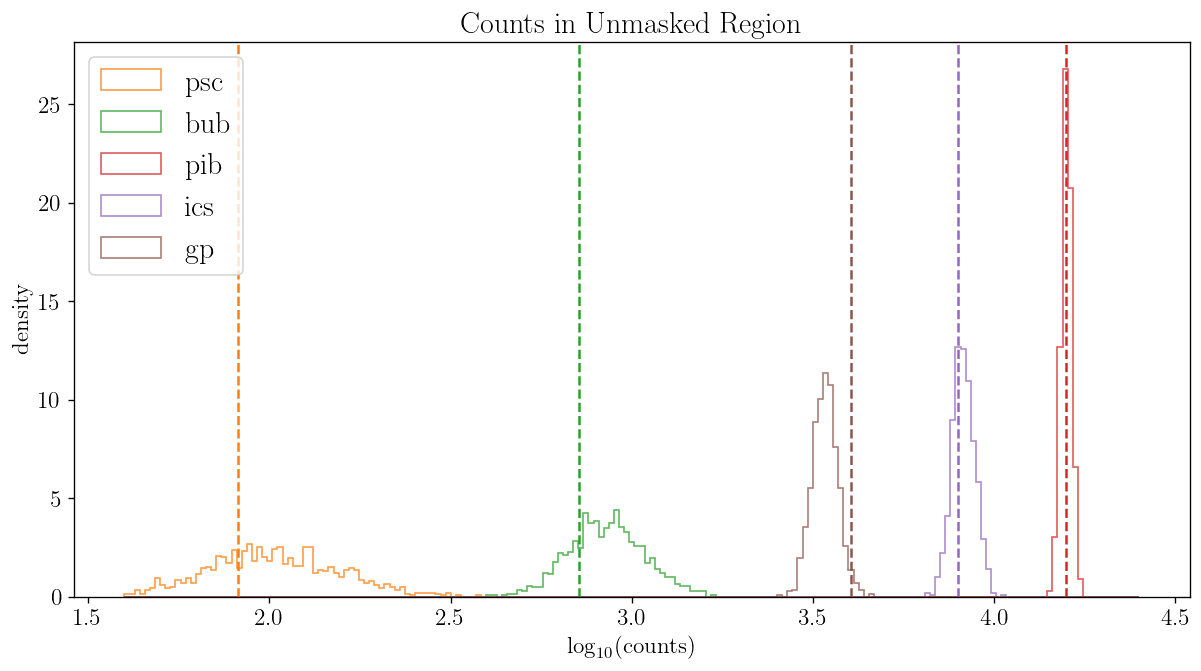

In [23]:
# generate samples and plot histograms of log counts

temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = gp_samples)
ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, bins = np.linspace(1.6,4.4,200), gp_model_nfw=True, gp_model_iso = True)

In [24]:
# 1D slice of GP posterior
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords()

exp_gp_samples = np.exp(gp_samples)
exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels=80, nside = 128)
q = np.percentile(exp_gp_samples_cart, [16,50,84], axis = 0)

gp_temp_list = [temp for temp in ebinmodel.temp_names_sim if temp not in ebinmodel.temp_list]
gp_true = np.array([temp_dict[temp] for temp in gp_temp_list]).sum(axis = 0)
sim_cart = ef.healpix_to_cart(gp_true, mask, n_pixels=80, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=80, nside = 128)

100%|██████████| 1000/1000 [00:07<00:00, 134.18it/s]


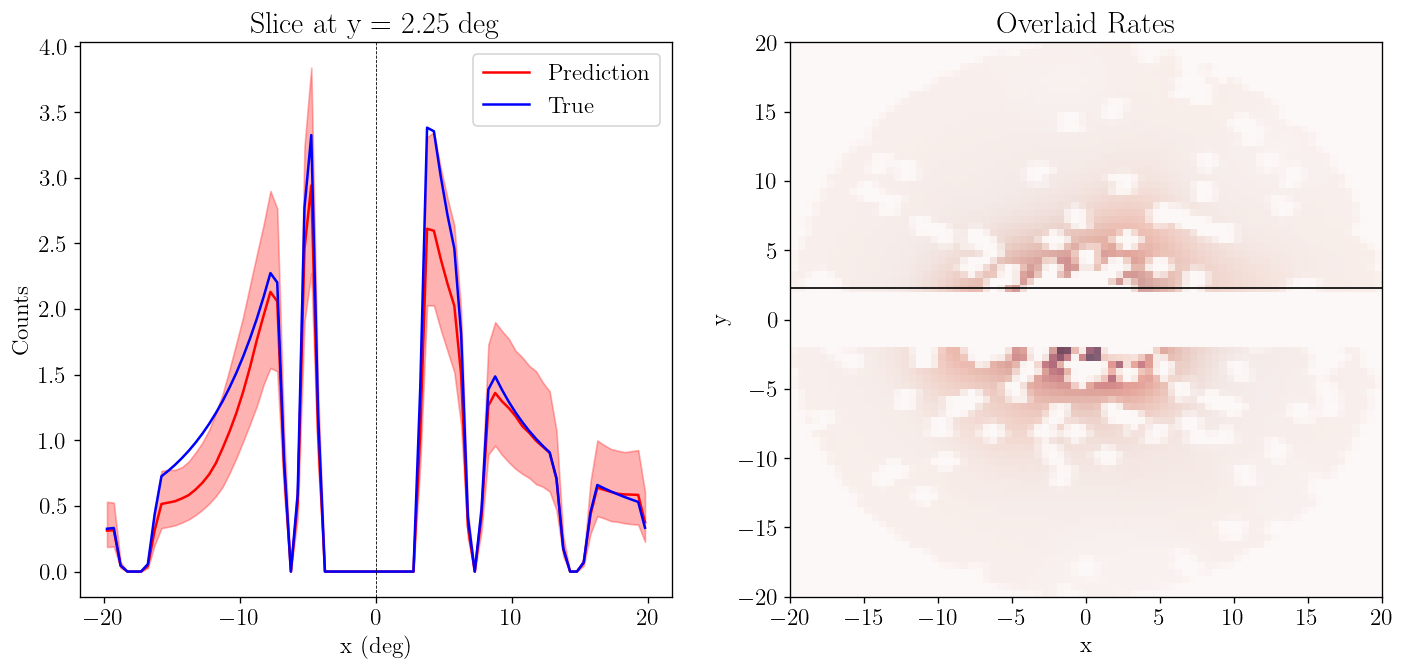

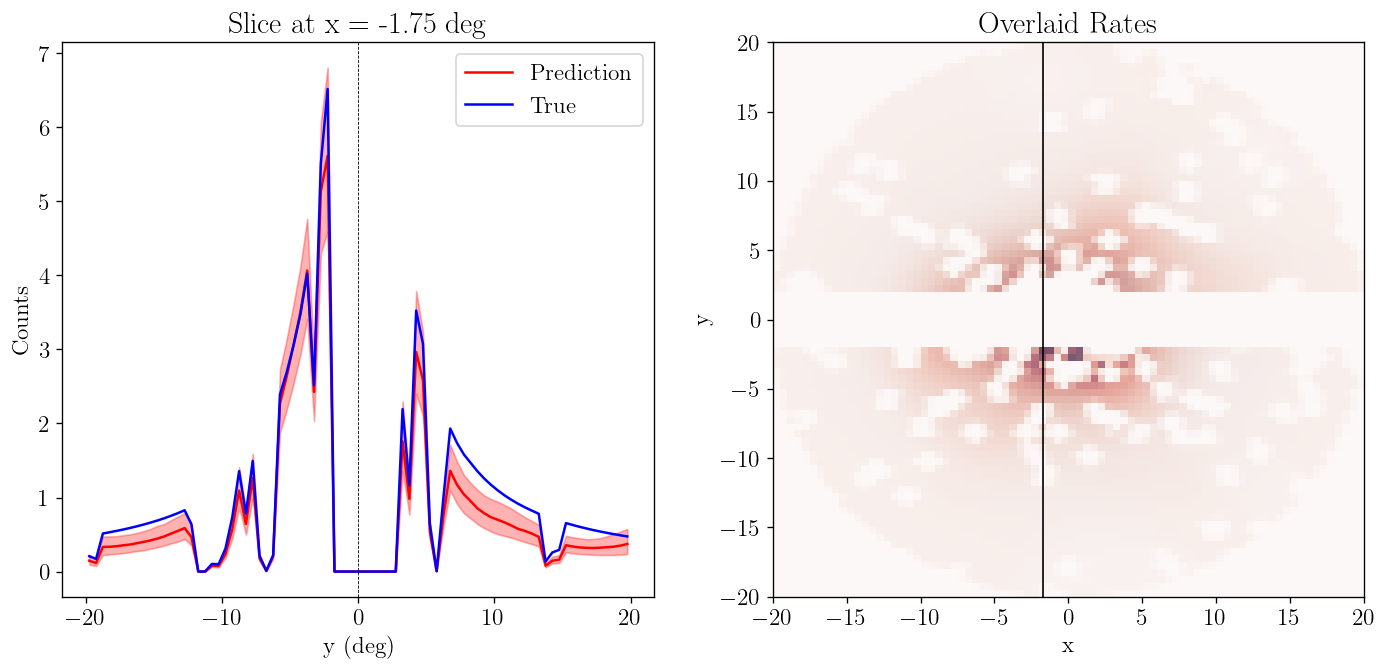

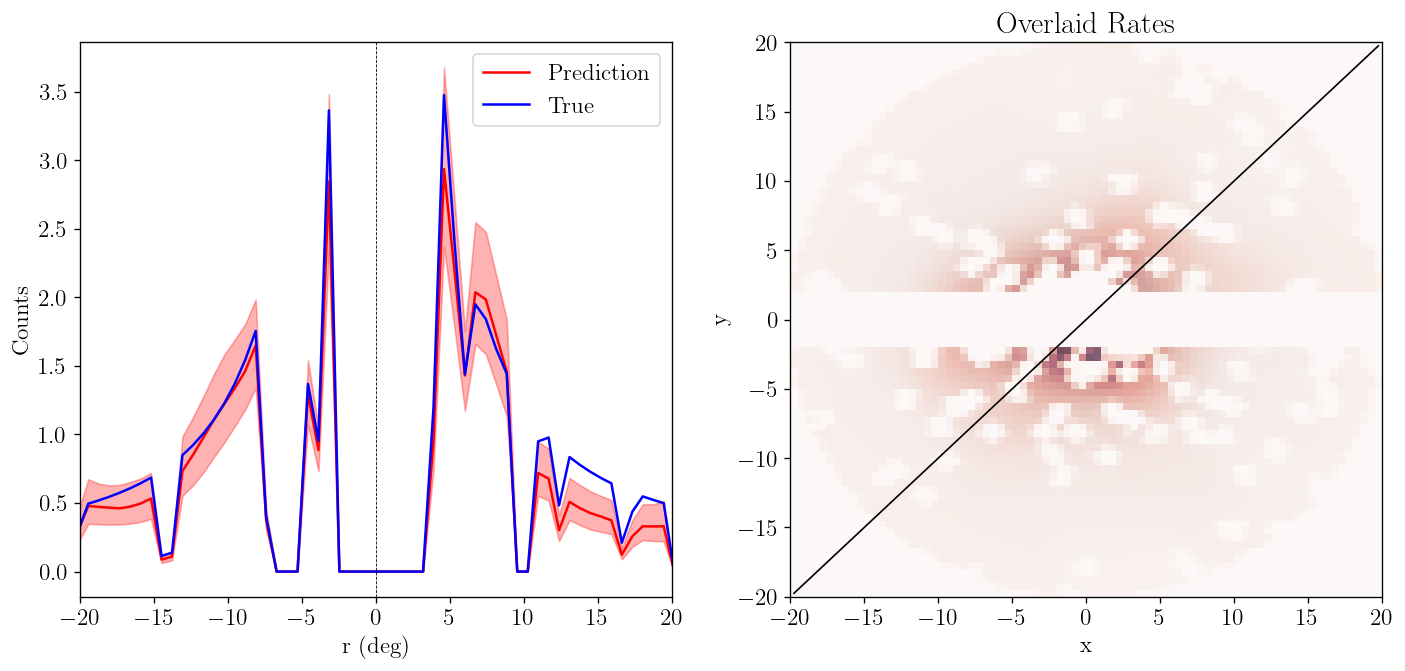

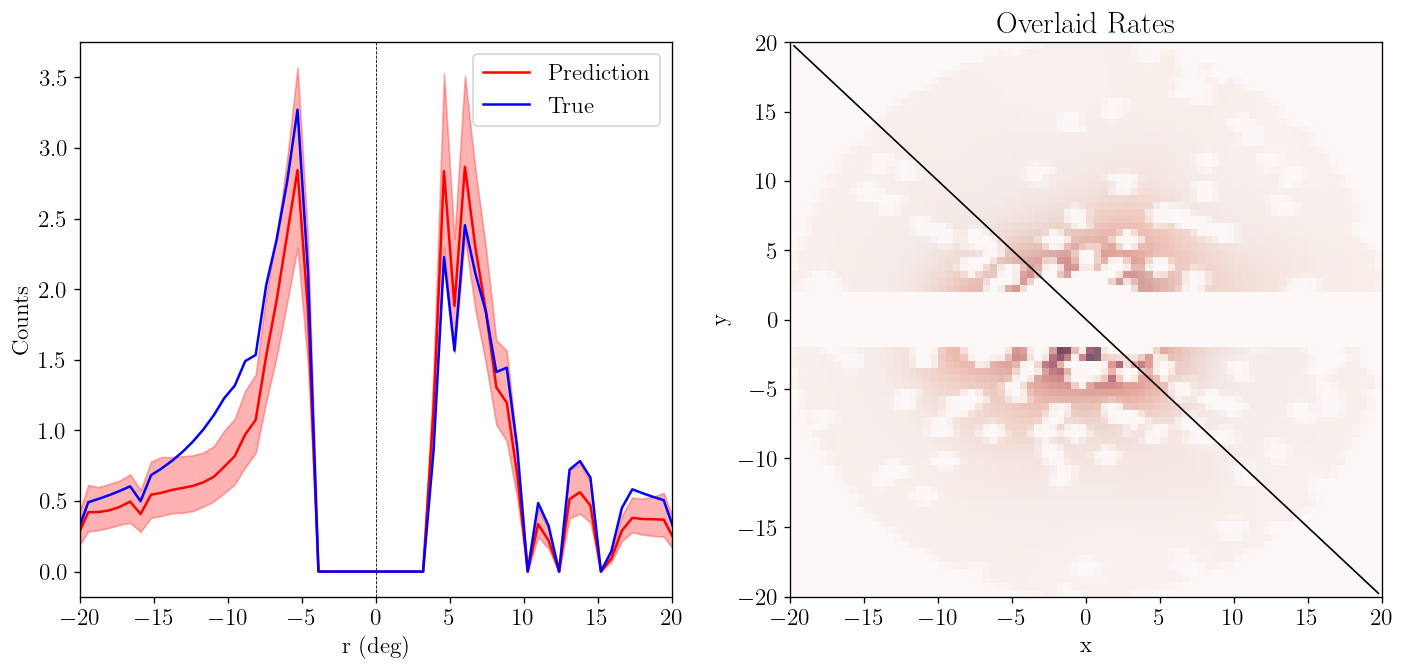

In [25]:
# 1D slice of GP posterior
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'horizontal', slice_val = 2., res_scale = 1, yscale = 'linear')
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'vertical', slice_val = -2., res_scale = 1, yscale = 'linear')
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_up', slice_val = 10., res_scale = 1, yscale = 'linear')
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_down', slice_val = 10., res_scale = 1, yscale = 'linear')

In [26]:
# 1D slice of full posterior
tot_samples = jnp.zeros(temp_sample_dict['gp'].shape)
tot_names = list(temp_sample_dict.keys())
for tot_name in tot_names:
    tot_samples += temp_sample_dict[tot_name]

tot_samples_cart = ef.multi_healpix_to_cart(tot_samples, mask, n_pixels=80, nside = 128)
q_tot = np.percentile(tot_samples_cart, [16,50,84], axis = 0)

sim_samples = jnp.zeros(temp_dict['blg'].shape)
for sim_name in temp_names_sim:
    sim_samples += temp_dict[sim_name]
sim_cart = ef.healpix_to_cart(sim_samples, mask, n_pixels=80, nside = 128)

raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=80, nside = 128)

100%|██████████| 1000/1000 [00:10<00:00, 98.86it/s]


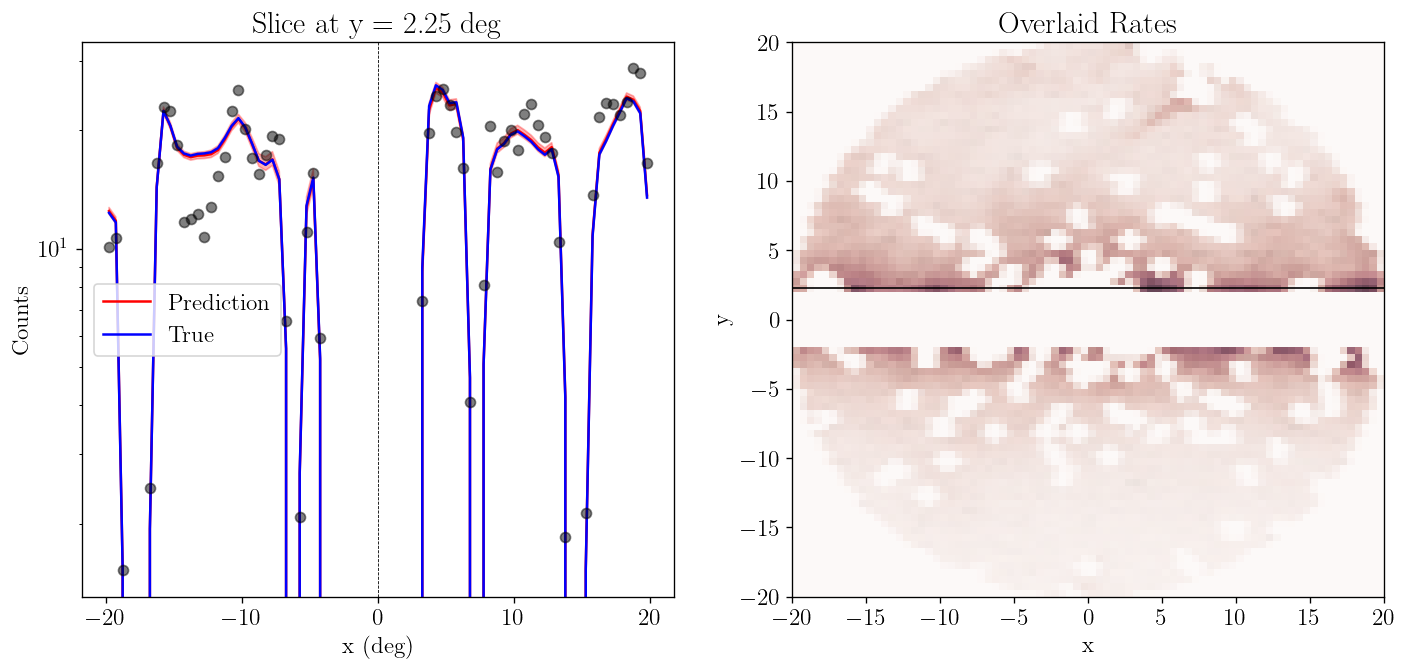

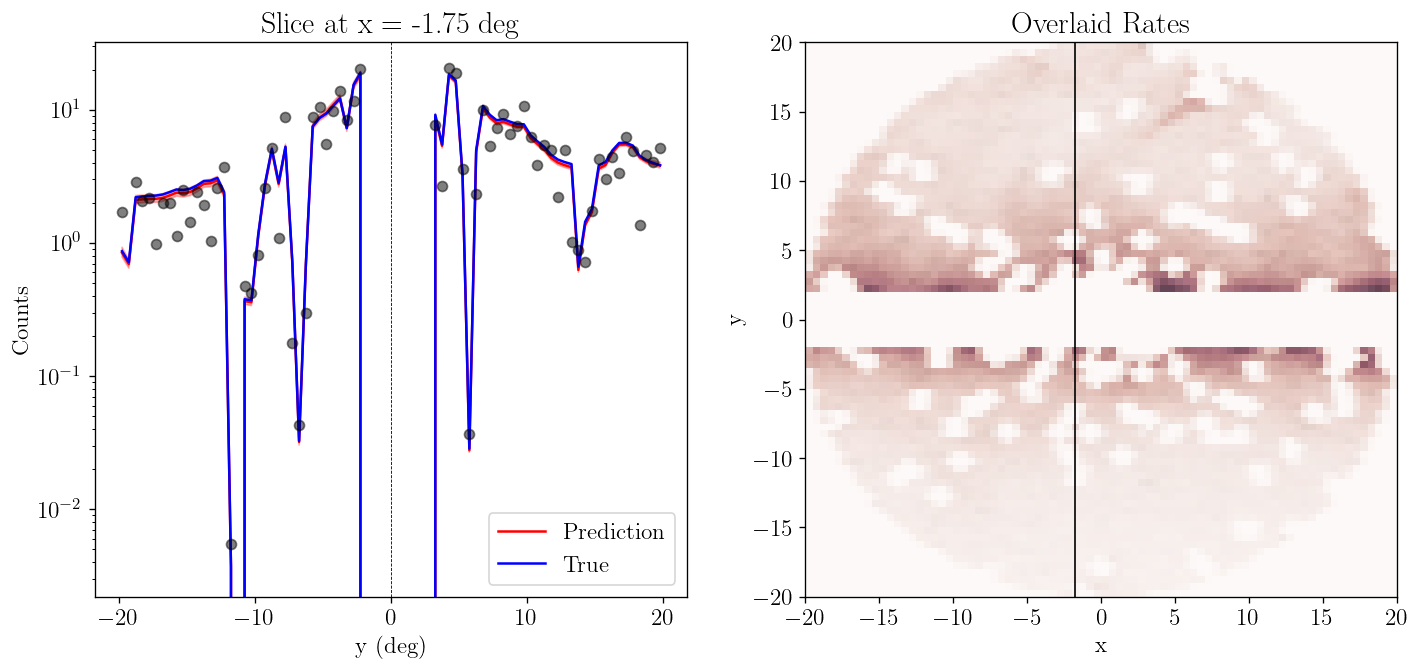

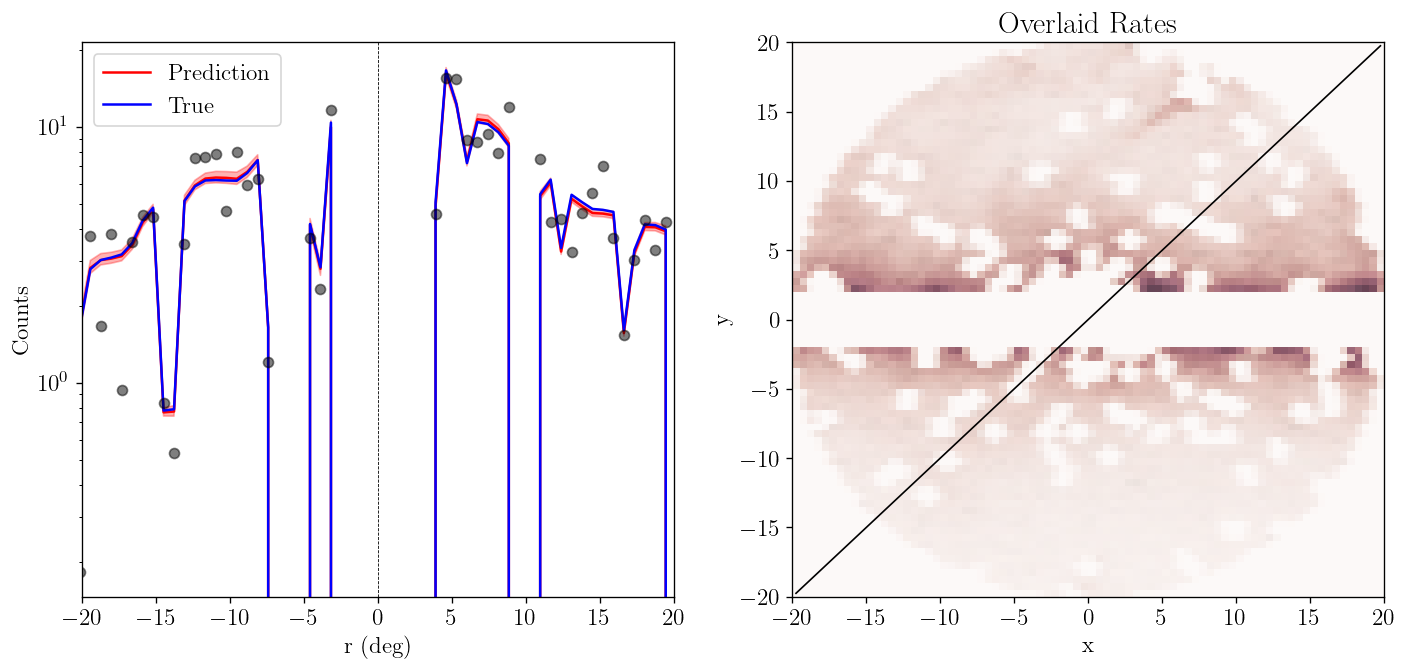

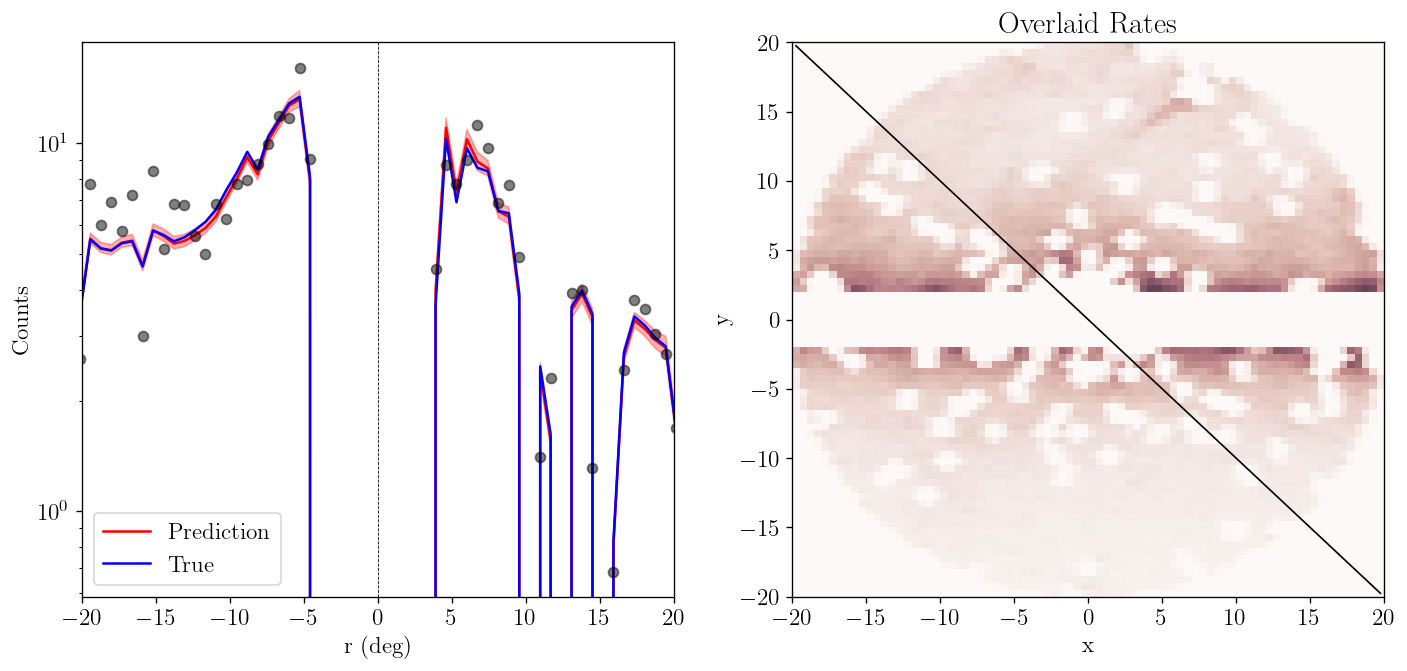

In [27]:
# 1D slice of full posterior
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'horizontal', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'vertical', slice_val = -2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'diagonal_up', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'diagonal_down', slice_val = 2., res_scale = 1)

In [28]:
# save svi results and samples to file
file_name = ('ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')
if is_gp:
    pickle.dump(
        (samples, svi_results, gp_samples), 
        open(fit_dir + file_name, 'wb'))
else:
    pickle.dump(
        (samples, svi_results), 
        open(fit_dir + file_name, 'wb'))

In [29]:
# INPUT CELL

# Temps -> GP [Poissonian kl-minimization]
ebinmodel.Nsub = 500
ebinmodel.nfw_gamma = 'vary'
ebinmodel.config_temp_model(params = svi_results.params)

ebin = 10
str_ebin = str(ebin)

guide = 'mvn'
str_guide = guide

n_steps = 15000
str_n_steps = str(n_steps)

lr = 0.02  
str_lr = str(lr)   # BE SURE TO CHANGE THIS

num_particles = 16
str_num_particles = str(num_particles)

svi_seed = 193
str_svi_seed = str(svi_seed)

rng_key, key = jax.random.split(rng_key)
temp_svi_results = ebinmodel.cfit_SVI(
    rng_key=key,
    guide=guide, 
    n_steps=n_steps, 
    lr=lr, 
    num_particles=num_particles,
    ebin=ebin, early_stop = np.inf, optimizer = optimizer
)
rng_key, key = jax.random.split(rng_key)
temp_samples = ebinmodel.cget_svi_samples(rng_key = key, num_samples=50000)

100%|██████████| 15000/15000 [07:15<00:00, 34.47it/s, init loss: 97609.0781, min loss 4023.9438, avg loss [14926-15000]: 4773.4077]


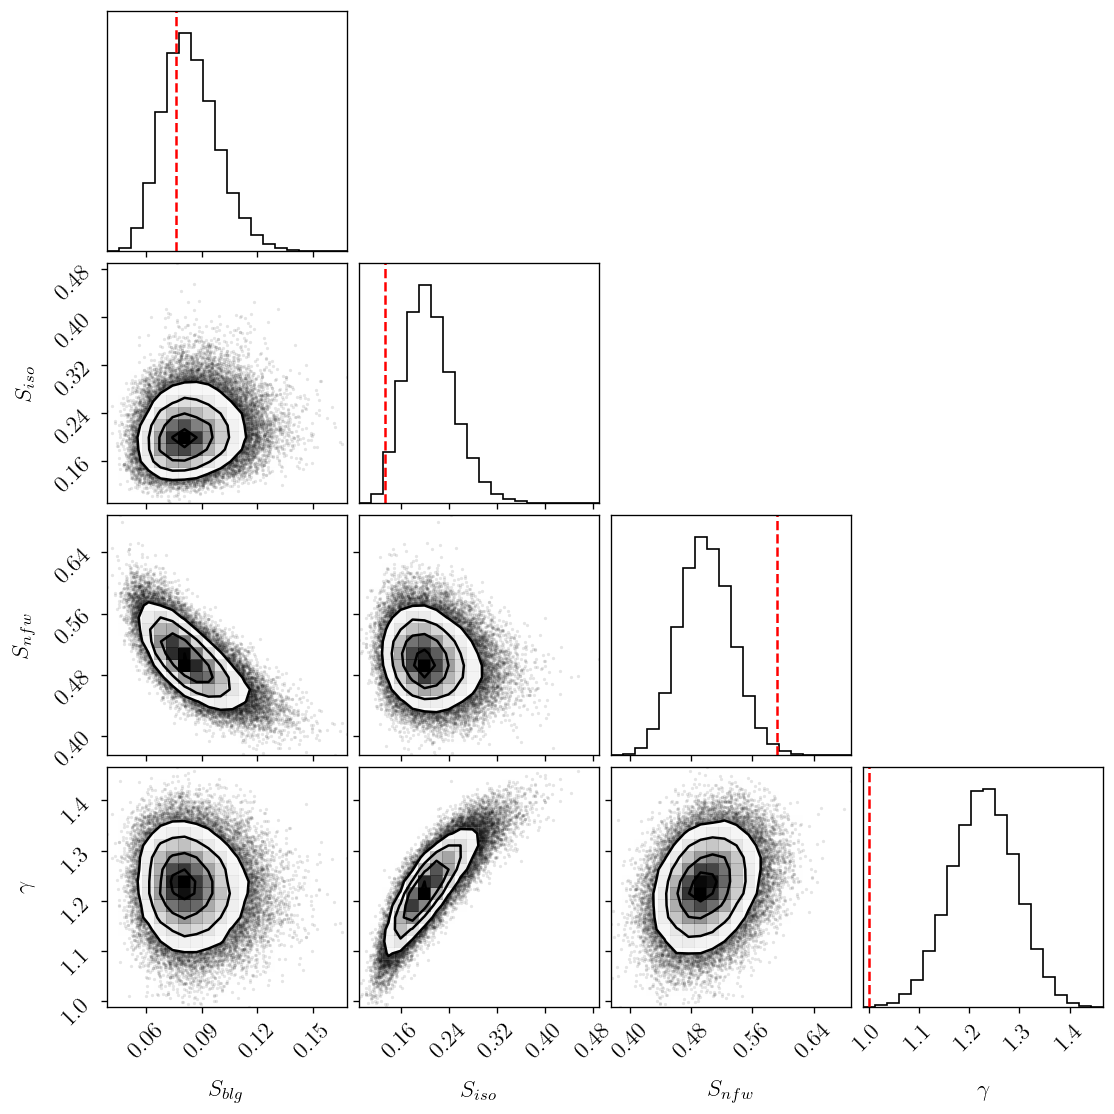

In [30]:
import corner

keys = ['S_blg', 'S_iso', 'S_nfw', 'gamma']
labels = ['$S_{blg}$','$S_{iso}$', '$S_{nfw}$','$\\gamma$']
Nl = len(labels)
temp_samples_tot = [temp_samples[key] for key in keys]
temp_samples_tot = np.array(temp_samples_tot).T

fig = corner.corner(np.array(temp_samples_tot), labels = labels)
axes = np.array(fig.axes).reshape((Nl, Nl))
p_tr = [true_params[key] for key in keys]
for i in range(Nl):
    ax = axes[i,i]
    ax.axvline(p_tr[i], color='red', linestyle='--')

In [31]:
ie = ebin
temp_samples_red = {}
for k in list(temp_samples.keys()):
    temp_samples_red[k] = temp_samples[k][:1000]

S_iso = temp_samples_red['S_iso']
S_nfw = temp_samples_red['S_nfw']
S_blg = temp_samples_red['S_blg']
gamma = temp_samples_red['gamma']

temp_sample_dict_2 = {}
temp_sample_dict_2['iso'] = S_iso[:,None] * jnp.asarray(ebinmodel.temps['iso'].at_bin(ie, mask=mask))[None,:]
temp_sample_dict_2['blg'] = S_blg[:,None] * jnp.asarray(ebinmodel.blg_temps[0].at_bin(ie, mask=mask)[None,:])

if 'nfw' in ebinmodel.gp_temp_list:
    if ebinmodel.nfw_gamma == 'vary':
        get_NFW2_template_vec = jax.vmap(ebinmodel.nfw_temp.get_NFW2_template) # shape is correct
        temp_sample_dict_2['nfw'] = S_nfw[:,None] * get_NFW2_template_vec(gamma=gamma)[:,~mask]

In [32]:
temp_sample_2_sum = np.array([temp_sample_dict_2[k] for k in list(temp_sample_dict_2.keys())]).sum(axis=0)
temp_sample_2_sum_cart = ef.multi_healpix_to_cart(temp_sample_2_sum, mask, n_pixels=80, nside = 128)
q2 = np.percentile(temp_sample_2_sum_cart, [16,50,84], axis = 0)

100%|██████████| 1000/1000 [00:07<00:00, 137.02it/s]


Text(0, 0.5, 'y')

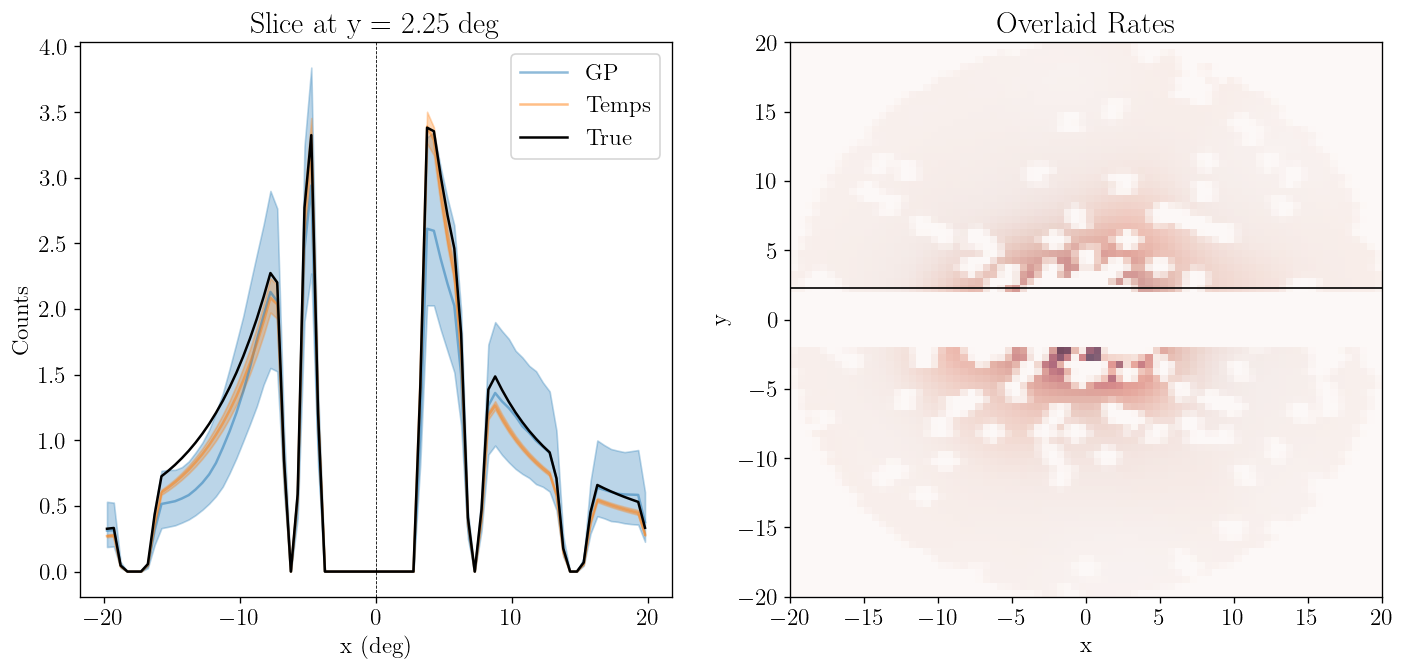

In [33]:
fig = plt.figure(figsize=(14, 6), dpi= 120)

sim_cart = ef.healpix_to_cart(gp_true, mask, n_pixels=80, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=80, nside = 128)

blg_coord = sim_cart
sim_coord = None
res_scale = 1
yscale = 'linear'

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

y_slice = 2.
ny = np.where(np.abs(x2_c - y_slice) < 0.5 * res_scale)[0][1]

ccode = 'C0'
ax1.plot(x[ny,:,0], q[1][ny,:], c = ccode, label = str('GP'), alpha = 0.5)
ax1.fill_between(x[ny,:,0], q[0][ny,:], q[2][ny,:], color = ccode, alpha = 0.3)

ccode = 'C1'
ax1.plot(x[ny,:,0], q2[1][ny,:], c = ccode, label = str('Temps'), alpha = 0.5)
ax1.fill_between(x[ny,:,0], q2[0][ny,:], q2[2][ny,:], color = ccode, alpha = 0.3)

ax1.plot(x[ny,:,0], blg_coord[ny,:], c = 'k', label = 'True')
if sim_coord is not None:
    ax1.errorbar(x[ny,:,0], sim_coord[ny,:], fmt = 'o', c = 'k', alpha = 0.5)
ax1.set_xlabel('x (deg)')
ax1.set_ylabel('Counts')
ax1.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax1.legend(fontsize = 14)
ax1.axvline(0, color='k', ls = '--', lw = 0.5)
ax1.set_yscale(yscale)

ax2.pcolormesh(x1_plt, x2_plt, blg_coord, cmap='Blues', alpha = 0.5)
ax2.pcolormesh(x1_plt, x2_plt, q[1], cmap='Reds', alpha = 0.5)
if sim_coord is not None:
    ax2.pcolormesh(x1_plt, x2_plt, sim_coord, cmap='Greys', alpha = 0.2)
ax2.axhline(y = x[ny,0,1], c = 'k', lw = 1)
ax2.set_title('Overlaid Rates')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

In [34]:
# save second fit data

file_name = ('gp2temp_' + 'ebin' + str_ebin + '_smp_svi_' + 
        str_lr + '_' + str_n_steps + '_' + 
            str_guide + '_' + str_num_particles + '_' + 
            str_sim_seed + '_' + str_svi_seed + '.p')

file_name_res = ('gp2temp_' +'ebin' + str_ebin + '_svi_res_' + 
        str_lr + '_' + str_n_steps + '_' + 
            str_guide + '_' + str_num_particles + '_' + 
            str_sim_seed + '_' + str_svi_seed + '.p')

pickle.dump(
    (temp_samples, temp_svi_results), 
    open(fit_dir + file_name, 'wb'))

pickle.dump(
    (temp_svi_results), 
    open(fit_dir + file_name_res, 'wb'))

In [35]:
print(fit_dir + file_name)

/data/edr76/gce-prob-prog-gp/data/synthetic_data/canon_g1/fits/fit_7p1234567_4p3457_1p126_-1_0_0/seed_0_0/gp2temp_ebin10_smp_svi_0.02_15000_mvn_16_0_193.p
